# KO the CIFAR with ResNet

In the world of deep learning, the selection of datasets and the architecture of models are crucial for ultimate performance. The CIFAR-10/100 dataset, as a more complex image recognition task than MNIST, provides us with a challenging platform. In the previous chapter, we explored the application of Vision Transformer (ViT) on the CIFAR dataset and pointed out its limitations on small datasets. In this chapter, we will return to deep convolutional neural networks (CNNs), especially the ResNet architecture, and explore how to further improve the performance of the model on the CIFAR-10/100 dataset through carefully designed training strategies.

## ResNet architecture review

ResNet solves the degradation problem in deep network training by introducing residual learning, allowing us to build deeper networks without worrying about vanishing or exploding gradients. ResNet has shown higher accuracy than traditional CNN on the CIFAR dataset.

In this chapter, we use ResNet18, which is more complex than the custom ResNet in Chapter 8, and make some adjustments to make it suitable for the CIFAR dataset

In [1]:
import torch
import torch.nn as nn

class ResNet(nn.Module):
    def __init__(self, input_channels, num_classes, zero_init_residual=False, groups=1, width_per_group=64):
        super(ResNet, self).__init__()
        
        norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1

        self.groups = groups
        self.base_width = width_per_group

        self.conv1 = nn.Conv2d(input_channels, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.blocks_layer = nn.Sequential(
            self._make_layer(BasicBlock, 64, 2),
            self._make_layer(BasicBlock, 128, 2, stride=2, dilate=False),
            self._make_layer(BasicBlock, 256, 2, stride=2, dilate=False),
            self._make_layer(BasicBlock, 512, 2, stride=2, dilate=False)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

        self._initialize_weights(zero_init_residual)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups, base_width=self.base_width, dilation=self.dilation, norm_layer=norm_layer))
        return nn.Sequential(*layers)

    def _initialize_weights(self, zero_init_residual):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.blocks_layer(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1, base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

## Adjust the Trainer

In terms of training, we defined a Cutout function that can randomly apply black patches to images for further data augmentation to improve the robustness of the model. In the training of the model, we adopt a strategy of setting the initial learning rate to 0.1. Whenever the validation set loss does not decrease after 10 epochs of training, the learning rate becomes the original 0.5, and a total of 250 epochs are trained.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np
import random
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import matplotlib.pyplot as plt
import datetime


class CIFARTrainer:
    def __init__(self, model, batch_size, epoch, num_classes, seed=1234):
        self.model = model
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.epoch = epoch
        self.seed = seed
        self.loss_f = nn.CrossEntropyLoss()

        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []

        """load model, loss_fn and optimizer"""
        if torch.cuda.is_available():
            self.model = self.model.cuda()
        if torch.cuda.is_available():
            self.loss_f = self.loss_f.cuda()
        self.scaler = GradScaler()

        """download and allocate data"""
        self.ROOT = '.data'
        if num_classes==10:
            self.train_valid_data = torchvision.datasets.CIFAR10(root=self.ROOT, train=True, download=True)
            self.test_data = torchvision.datasets.CIFAR10(root=self.ROOT, train=False, download=True)
        elif num_classes==100:
            self.train_valid_data = torchvision.datasets.CIFAR100(root=self.ROOT, train=True, download=True)
            self.test_data = torchvision.datasets.CIFAR100(root=self.ROOT, train=False, download=True)
            
        self.VALID_RATE = 0.1
        self.train_data, self.valid_data = torch.utils.data.random_split(self.train_valid_data,
                                                               [int(len(self.train_valid_data) * (1 - self.VALID_RATE)),
                                                                int(len(self.train_valid_data) * self.VALID_RATE)])


        """data augmentation"""
        self.train_transforms = torchvision.transforms.Compose([
            torchvision.transforms.RandomCrop(32, padding=4),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
            Cutout(n_holes=2, length=16)
        ])
        self.test_transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        ])

        self.train_data.dataset.transform = self.train_transforms
        self.valid_data.dataset.transform = self.test_transforms
        self.test_data.transform = self.test_transforms

        """load data"""
        self.train_dataloader = torch.utils.data.DataLoader(self.train_data, shuffle=True, batch_size=self.batch_size)
        self.valid_dataloader = torch.utils.data.DataLoader(self.valid_data, batch_size=self.batch_size)
        self.test_dataloader = torch.utils.data.DataLoader(self.test_data, batch_size=self.batch_size)

        """set the seed"""
        random.seed(self.seed)
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        torch.cuda.manual_seed(self.seed)
        torch.backends.cudnn.deterministic = True

    def train(self):
        valid_loss_min = np.Inf
        counter = 0
        lr = 0.1
        for epoch in range(self.epoch):
            print('=' * 135)
            print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
            print(f"Epoch {epoch + 1} / {self.epoch}")
    
            if counter/10 ==1:
                counter = 0
                lr = lr*0.5
                print(f"lr is updated to {lr}")
            optimizer_f = optim.SGD(self.model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
            
            self.model.train()
            train_bar = tqdm(self.train_dataloader, desc="[Train]", ncols=90)
            train_losses = []
            for inputs, targets in train_bar:
                if torch.cuda.is_available():
                    inputs, targets = inputs.cuda(), targets.cuda()
                optimizer_f.zero_grad()
                with autocast(enabled=torch.cuda.is_available()):
                    outputs = self.model(inputs)
                    loss = self.loss_f(outputs, targets)
                    
                self.scaler.scale(loss).backward()
                self.scaler.step(optimizer_f)
                self.scaler.update()
                train_losses.append(loss.item())
                train_bar.set_postfix(train_loss=sum(train_losses) / len(train_bar))
            train_bar.close()
            self.train_losses.append(sum(train_losses) / len(train_bar))

            self.model.eval()
            valid_loss = 0
            valid_accuracy = 0
            valid_samples = 0
            valid_bar = tqdm(self.valid_dataloader, desc="[Valid]", ncols=100)
            with torch.no_grad():
                for inputs, targets in valid_bar:
                    if torch.cuda.is_available():
                        inputs, targets = inputs.cuda(), targets.cuda()
                    outputs = self.model(inputs)
                    loss = self.loss_f(outputs, targets)

                    valid_loss += loss.item()
                    pred = outputs.argmax(1)
                    correct = (pred == targets).sum().item()
                    valid_accuracy += correct
                    valid_samples += targets.size(0)
                    val_loss = valid_loss / valid_samples
                    val_acc = valid_accuracy / valid_samples
                    valid_bar.set_postfix(val_loss=val_loss, val_acc=val_acc * 100)
                    
            valid_bar.close()
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)
            
            if val_loss <= valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,val_loss))
                if self.num_classes==10:
                    torch.save(model.state_dict(), './.ipynb_checkpoints/resnet18_cifar10.pt')
                elif self.num_classes==100:
                    torch.save(model.state_dict(), './.ipynb_checkpoints/resnet18_cifar100.pt')
                valid_loss_min = val_loss
                counter = 0
            else:
                counter += 1

        self.plot_training()

    def plot_training(self):
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, self.epoch + 1), self.train_losses, label='Train Loss')
        plt.plot(range(1, self.epoch + 1), self.val_losses, label='Val Loss')
        plt.plot(range(1, self.epoch + 1), self.val_accuracies, label='Val Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Metrics')
        plt.title('Training Progress')
        plt.legend()
        plt.show()

    def test(self):
        if self.num_classes==10:
            torch.save(model.state_dict(), './.ipynb_checkpoints/resnet18_cifar10.pt')
        elif self.num_classes==100:
            torch.save(model.state_dict(), './.ipynb_checkpoints/resnet18_cifar100.pt')
        self.model.eval()
        total_test_loss = 0
        total_test_accuracy = 0
        num_samples = 0
        test_bar = tqdm(self.test_dataloader, desc="Testing [Test]")
        with torch.no_grad():
            for inputs, targets in test_bar:
                if torch.cuda.is_available():
                    inputs = inputs.cuda()
                    targets = targets.cuda()
                outputs = self.model(inputs)
                loss = self.loss_f(outputs, targets)

                total_test_loss += loss.item()
                accuracy = (outputs.argmax(1) == targets).sum().item()
                total_test_accuracy += accuracy
                num_samples += len(inputs)
                test_bar.set_postfix(test_loss=total_test_loss / num_samples,
                                     test_acc=total_test_accuracy / num_samples * 100)
                test_bar.update()
        test_bar.close()
    
    
class Cutout(object):
    """
    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

## Start Training

In my personal experiment, I set the epoch to 250. But in reality, I found that after reaching epoch 100, the model's valid loss tends to stabilize and is difficult to further reduce (both CIFAR10 and CIFAR100). So here, in order to save time and computing resources, you can modify the epoch to 100.

Files already downloaded and verified
Files already downloaded and verified
2024-05-23 00:38:05
Epoch 1 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 15.34it/s, val_acc=45.5, val_loss=0.0119]


Validation loss decreased (inf --> 0.011865).  Saving model ...
2024-05-23 00:38:43
Epoch 2 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 15.34it/s, val_acc=58.7, val_loss=0.00915]


Validation loss decreased (0.011865 --> 0.009150).  Saving model ...
2024-05-23 00:39:23
Epoch 3 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.49it/s, val_acc=64.7, val_loss=0.0078]


Validation loss decreased (0.009150 --> 0.007805).  Saving model ...
2024-05-23 00:40:07
Epoch 4 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.15it/s, val_acc=70.6, val_loss=0.00698]


Validation loss decreased (0.007805 --> 0.006976).  Saving model ...
2024-05-23 00:40:54
Epoch 5 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 13.76it/s, val_acc=76.9, val_loss=0.0053]


Validation loss decreased (0.006976 --> 0.005297).  Saving model ...
2024-05-23 00:41:41
Epoch 6 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.27it/s, val_acc=74.1, val_loss=0.00612]


2024-05-23 00:42:29
Epoch 7 / 250


[Valid]: 100%|█████████████████████████| 40/40 [00:02<00:00, 14.09it/s, val_acc=78, val_loss=0.0052]


Validation loss decreased (0.005297 --> 0.005198).  Saving model ...
2024-05-23 00:43:15
Epoch 8 / 250


[Valid]: 100%|████████████████████████| 40/40 [00:03<00:00, 13.25it/s, val_acc=76, val_loss=0.00587]


2024-05-23 00:44:02
Epoch 9 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.23it/s, val_acc=76.5, val_loss=0.00594]


2024-05-23 00:44:48
Epoch 10 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.25it/s, val_acc=77.4, val_loss=0.00569]


2024-05-23 00:45:33
Epoch 11 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.28it/s, val_acc=76.9, val_loss=0.00586]


2024-05-23 00:46:17
Epoch 12 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.56it/s, val_acc=76.1, val_loss=0.00625]


2024-05-23 00:47:02
Epoch 13 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.77it/s, val_acc=75.8, val_loss=0.00642]


2024-05-23 00:47:46
Epoch 14 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:03<00:00, 13.03it/s, val_acc=77.8, val_loss=0.00563]


2024-05-23 00:48:30
Epoch 15 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.61it/s, val_acc=77.5, val_loss=0.00596]


2024-05-23 00:49:17
Epoch 16 / 250


[Valid]: 100%|████████████████████████| 40/40 [00:02<00:00, 14.84it/s, val_acc=78, val_loss=0.00609]


2024-05-23 00:50:07
Epoch 17 / 250


[Valid]: 100%|████████████████████████| 40/40 [00:02<00:00, 13.95it/s, val_acc=78, val_loss=0.00541]


2024-05-23 00:50:56
Epoch 18 / 250
lr is updated to 0.05


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.18it/s, val_acc=85.1, val_loss=0.00418]


Validation loss decreased (0.005198 --> 0.004175).  Saving model ...
2024-05-23 00:51:42
Epoch 19 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 13.97it/s, val_acc=86.7, val_loss=0.00374]


Validation loss decreased (0.004175 --> 0.003742).  Saving model ...
2024-05-23 00:52:28
Epoch 20 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 13.68it/s, val_acc=87.1, val_loss=0.00373]


Validation loss decreased (0.003742 --> 0.003725).  Saving model ...
2024-05-23 00:53:15
Epoch 21 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.16it/s, val_acc=87.8, val_loss=0.00347]


Validation loss decreased (0.003725 --> 0.003467).  Saving model ...
2024-05-23 00:54:03
Epoch 22 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.71it/s, val_acc=87.9, val_loss=0.00339]


Validation loss decreased (0.003467 --> 0.003392).  Saving model ...
2024-05-23 00:54:49
Epoch 23 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.55it/s, val_acc=87.9, val_loss=0.00333]


Validation loss decreased (0.003392 --> 0.003330).  Saving model ...
2024-05-23 00:55:34
Epoch 24 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.50it/s, val_acc=88.1, val_loss=0.00328]


Validation loss decreased (0.003330 --> 0.003281).  Saving model ...
2024-05-23 00:56:18
Epoch 25 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.73it/s, val_acc=88.1, val_loss=0.00327]


Validation loss decreased (0.003281 --> 0.003268).  Saving model ...
2024-05-23 00:57:03
Epoch 26 / 250


[Valid]: 100%|████████████████████████| 40/40 [00:02<00:00, 14.71it/s, val_acc=88, val_loss=0.00325]


Validation loss decreased (0.003268 --> 0.003249).  Saving model ...
2024-05-23 00:57:46
Epoch 27 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.68it/s, val_acc=88.1, val_loss=0.00325]


Validation loss decreased (0.003249 --> 0.003246).  Saving model ...
2024-05-23 00:58:29
Epoch 28 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.78it/s, val_acc=87.8, val_loss=0.00327]


2024-05-23 00:59:13
Epoch 29 / 250


[Valid]: 100%|████████████████████████| 40/40 [00:02<00:00, 14.81it/s, val_acc=88, val_loss=0.00337]


2024-05-23 00:59:58
Epoch 30 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.17it/s, val_acc=76.8, val_loss=0.00574]


2024-05-23 01:00:42
Epoch 31 / 250


[Valid]: 100%|████████████████████████| 40/40 [00:02<00:00, 14.63it/s, val_acc=81, val_loss=0.00466]


2024-05-23 01:01:27
Epoch 32 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.62it/s, val_acc=79.7, val_loss=0.00534]


2024-05-23 01:02:13
Epoch 33 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 15.41it/s, val_acc=79.9, val_loss=0.00559]


2024-05-23 01:02:58
Epoch 34 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.33it/s, val_acc=79.4, val_loss=0.00576]


2024-05-23 01:03:43
Epoch 35 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.72it/s, val_acc=81.6, val_loss=0.0053]


2024-05-23 01:04:28
Epoch 36 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.58it/s, val_acc=75.6, val_loss=0.00758]


2024-05-23 01:05:12
Epoch 37 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.87it/s, val_acc=79.8, val_loss=0.00624]


2024-05-23 01:05:55
Epoch 38 / 250
lr is updated to 0.025


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.83it/s, val_acc=86.9, val_loss=0.00384]


2024-05-23 01:06:39
Epoch 39 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.69it/s, val_acc=87.5, val_loss=0.00366]


2024-05-23 01:07:25
Epoch 40 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.46it/s, val_acc=87.7, val_loss=0.00353]


2024-05-23 01:08:09
Epoch 41 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.57it/s, val_acc=87.6, val_loss=0.00346]


2024-05-23 01:08:54
Epoch 42 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.50it/s, val_acc=87.7, val_loss=0.0034]


2024-05-23 01:09:38
Epoch 43 / 250


[Valid]: 100%|████████████████████████| 40/40 [00:02<00:00, 14.37it/s, val_acc=88, val_loss=0.00335]


2024-05-23 01:10:22
Epoch 44 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.28it/s, val_acc=88.1, val_loss=0.0033]


2024-05-23 01:11:07
Epoch 45 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.51it/s, val_acc=88.2, val_loss=0.00329]


2024-05-23 01:11:51
Epoch 46 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 13.90it/s, val_acc=88.1, val_loss=0.00326]


2024-05-23 01:12:37
Epoch 47 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.78it/s, val_acc=88.1, val_loss=0.00324]


Validation loss decreased (0.003246 --> 0.003235).  Saving model ...
2024-05-23 01:13:21
Epoch 48 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.02it/s, val_acc=88.2, val_loss=0.00322]


Validation loss decreased (0.003235 --> 0.003222).  Saving model ...
2024-05-23 01:14:07
Epoch 49 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.08it/s, val_acc=88.2, val_loss=0.00322]


2024-05-23 01:14:52
Epoch 50 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.25it/s, val_acc=88.4, val_loss=0.0032]


Validation loss decreased (0.003222 --> 0.003201).  Saving model ...
2024-05-23 01:15:38
Epoch 51 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 13.97it/s, val_acc=88.1, val_loss=0.00323]


2024-05-23 01:16:23
Epoch 52 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.50it/s, val_acc=88.3, val_loss=0.00321]


2024-05-23 01:17:07
Epoch 53 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.61it/s, val_acc=88.3, val_loss=0.00319]


Validation loss decreased (0.003201 --> 0.003192).  Saving model ...
2024-05-23 01:17:53
Epoch 54 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.59it/s, val_acc=88.4, val_loss=0.00318]


Validation loss decreased (0.003192 --> 0.003184).  Saving model ...
2024-05-23 01:18:39
Epoch 55 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.50it/s, val_acc=88.4, val_loss=0.00321]


2024-05-23 01:19:23
Epoch 56 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.39it/s, val_acc=88.4, val_loss=0.00318]


Validation loss decreased (0.003184 --> 0.003177).  Saving model ...
2024-05-23 01:20:09
Epoch 57 / 250


[Valid]: 100%|████████████████████████| 40/40 [00:02<00:00, 14.55it/s, val_acc=88, val_loss=0.00322]


2024-05-23 01:20:53
Epoch 58 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.63it/s, val_acc=88.3, val_loss=0.00318]


2024-05-23 01:21:40
Epoch 59 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.42it/s, val_acc=88.2, val_loss=0.00321]


2024-05-23 01:22:25
Epoch 60 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.54it/s, val_acc=88.4, val_loss=0.0032]


2024-05-23 01:23:09
Epoch 61 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.16it/s, val_acc=88.2, val_loss=0.00322]


2024-05-23 01:23:54
Epoch 62 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.81it/s, val_acc=88.6, val_loss=0.0032]


2024-05-23 01:24:40
Epoch 63 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.45it/s, val_acc=88.5, val_loss=0.00322]


2024-05-23 01:25:25
Epoch 64 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 15.00it/s, val_acc=88.5, val_loss=0.00325]


2024-05-23 01:26:11
Epoch 65 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.44it/s, val_acc=67.3, val_loss=0.00783]


2024-05-23 01:26:56
Epoch 66 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.34it/s, val_acc=80.4, val_loss=0.00461]


2024-05-23 01:27:41
Epoch 67 / 250
lr is updated to 0.0125


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.41it/s, val_acc=84.6, val_loss=0.00378]


2024-05-23 01:28:26
Epoch 68 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.30it/s, val_acc=86.4, val_loss=0.00369]


2024-05-23 01:29:11
Epoch 69 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.28it/s, val_acc=87.4, val_loss=0.00349]


2024-05-23 01:29:57
Epoch 70 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.59it/s, val_acc=87.8, val_loss=0.00332]


2024-05-23 01:30:41
Epoch 71 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.15it/s, val_acc=87.5, val_loss=0.00344]


2024-05-23 01:31:26
Epoch 72 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.17it/s, val_acc=88.1, val_loss=0.00328]


2024-05-23 01:32:11
Epoch 73 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.44it/s, val_acc=88.1, val_loss=0.00326]


2024-05-23 01:32:56
Epoch 74 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.32it/s, val_acc=88.2, val_loss=0.00324]


2024-05-23 01:33:41
Epoch 75 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.40it/s, val_acc=88.2, val_loss=0.0032]


2024-05-23 01:34:26
Epoch 76 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.40it/s, val_acc=88.2, val_loss=0.00319]


2024-05-23 01:35:11
Epoch 77 / 250
lr is updated to 0.00625


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.52it/s, val_acc=88.2, val_loss=0.00319]


2024-05-23 01:35:55
Epoch 78 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.23it/s, val_acc=88.3, val_loss=0.00317]


Validation loss decreased (0.003177 --> 0.003166).  Saving model ...
2024-05-23 01:36:39
Epoch 79 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 15.01it/s, val_acc=88.1, val_loss=0.00316]


Validation loss decreased (0.003166 --> 0.003159).  Saving model ...
2024-05-23 01:37:25
Epoch 80 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.64it/s, val_acc=88.1, val_loss=0.00317]


2024-05-23 01:38:09
Epoch 81 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.34it/s, val_acc=88.3, val_loss=0.00315]


Validation loss decreased (0.003159 --> 0.003148).  Saving model ...
2024-05-23 01:38:54
Epoch 82 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 15.09it/s, val_acc=88.4, val_loss=0.00315]


2024-05-23 01:39:41
Epoch 83 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.26it/s, val_acc=88.3, val_loss=0.00315]


2024-05-23 01:40:26
Epoch 84 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.25it/s, val_acc=88.3, val_loss=0.00312]


Validation loss decreased (0.003148 --> 0.003124).  Saving model ...
2024-05-23 01:41:11
Epoch 85 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.58it/s, val_acc=88.4, val_loss=0.00313]


2024-05-23 01:41:56
Epoch 86 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.28it/s, val_acc=88.2, val_loss=0.00313]


2024-05-23 01:42:41
Epoch 87 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.52it/s, val_acc=88.3, val_loss=0.00315]


2024-05-23 01:43:25
Epoch 88 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.62it/s, val_acc=88.2, val_loss=0.00314]


2024-05-23 01:44:11
Epoch 89 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.80it/s, val_acc=88.4, val_loss=0.00312]


Validation loss decreased (0.003124 --> 0.003124).  Saving model ...
2024-05-23 01:44:55
Epoch 90 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.55it/s, val_acc=88.2, val_loss=0.00312]


Validation loss decreased (0.003124 --> 0.003118).  Saving model ...
2024-05-23 01:45:39
Epoch 91 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.36it/s, val_acc=88.4, val_loss=0.00313]


2024-05-23 01:46:25
Epoch 92 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.35it/s, val_acc=88.1, val_loss=0.00312]


2024-05-23 01:47:09
Epoch 93 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.02it/s, val_acc=88.3, val_loss=0.00315]


2024-05-23 01:47:56
Epoch 94 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.68it/s, val_acc=88.2, val_loss=0.00314]


2024-05-23 01:48:40
Epoch 95 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.78it/s, val_acc=88.1, val_loss=0.00312]


Validation loss decreased (0.003118 --> 0.003118).  Saving model ...
2024-05-23 01:49:26
Epoch 96 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.97it/s, val_acc=88.3, val_loss=0.00314]


2024-05-23 01:50:12
Epoch 97 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.74it/s, val_acc=88.3, val_loss=0.00313]


2024-05-23 01:50:57
Epoch 98 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.44it/s, val_acc=88.4, val_loss=0.00313]


2024-05-23 01:51:41
Epoch 99 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.83it/s, val_acc=88.2, val_loss=0.00313]


2024-05-23 01:52:26
Epoch 100 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 13.88it/s, val_acc=88.3, val_loss=0.00314]


2024-05-23 01:53:12
Epoch 101 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.76it/s, val_acc=88.4, val_loss=0.00314]


2024-05-23 01:53:57
Epoch 102 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.42it/s, val_acc=88.4, val_loss=0.00314]


2024-05-23 01:54:41
Epoch 103 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.52it/s, val_acc=88.2, val_loss=0.00317]


2024-05-23 01:55:26
Epoch 104 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 15.01it/s, val_acc=88.4, val_loss=0.00315]


2024-05-23 01:56:12
Epoch 105 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.72it/s, val_acc=88.4, val_loss=0.00313]


2024-05-23 01:56:56
Epoch 106 / 250
lr is updated to 0.003125


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.56it/s, val_acc=88.3, val_loss=0.00315]


2024-05-23 01:57:42
Epoch 107 / 250


[Valid]: 100%|████████████████████████| 40/40 [00:02<00:00, 14.62it/s, val_acc=88, val_loss=0.00316]


2024-05-23 01:58:25
Epoch 108 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.77it/s, val_acc=88.2, val_loss=0.00319]


2024-05-23 01:59:12
Epoch 109 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.61it/s, val_acc=88.3, val_loss=0.00316]


2024-05-23 01:59:58
Epoch 110 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 15.04it/s, val_acc=88.4, val_loss=0.00317]


2024-05-23 02:00:43
Epoch 111 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.44it/s, val_acc=88.3, val_loss=0.00315]


2024-05-23 02:01:30
Epoch 112 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.46it/s, val_acc=88.3, val_loss=0.00315]


2024-05-23 02:02:14
Epoch 113 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.44it/s, val_acc=88.3, val_loss=0.00315]


2024-05-23 02:02:58
Epoch 114 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.17it/s, val_acc=88.1, val_loss=0.00317]


2024-05-23 02:03:42
Epoch 115 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.29it/s, val_acc=88.3, val_loss=0.00316]


2024-05-23 02:04:27
Epoch 116 / 250
lr is updated to 0.0015625


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.38it/s, val_acc=88.2, val_loss=0.00316]


2024-05-23 02:05:11
Epoch 117 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.27it/s, val_acc=88.2, val_loss=0.00317]


2024-05-23 02:05:55
Epoch 118 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.47it/s, val_acc=88.3, val_loss=0.00317]


2024-05-23 02:06:40
Epoch 119 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.23it/s, val_acc=88.2, val_loss=0.00316]


2024-05-23 02:07:26
Epoch 120 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.33it/s, val_acc=88.1, val_loss=0.00317]


2024-05-23 02:08:11
Epoch 121 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.31it/s, val_acc=88.4, val_loss=0.00317]


2024-05-23 02:08:55
Epoch 122 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.79it/s, val_acc=88.3, val_loss=0.00316]


2024-05-23 02:09:39
Epoch 123 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.34it/s, val_acc=88.2, val_loss=0.00317]


2024-05-23 02:10:26
Epoch 124 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 13.97it/s, val_acc=88.2, val_loss=0.00317]


2024-05-23 02:11:11
Epoch 125 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 13.63it/s, val_acc=88.3, val_loss=0.00317]


2024-05-23 02:11:55
Epoch 126 / 250
lr is updated to 0.00078125


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 13.79it/s, val_acc=88.3, val_loss=0.00316]


2024-05-23 02:12:40
Epoch 127 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.08it/s, val_acc=88.4, val_loss=0.00315]


2024-05-23 02:13:27
Epoch 128 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.56it/s, val_acc=88.2, val_loss=0.00319]


2024-05-23 02:14:11
Epoch 129 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.44it/s, val_acc=88.3, val_loss=0.00316]


2024-05-23 02:14:55
Epoch 130 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.44it/s, val_acc=88.2, val_loss=0.00317]


2024-05-23 02:15:39
Epoch 131 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 15.01it/s, val_acc=88.1, val_loss=0.00316]


2024-05-23 02:16:25
Epoch 132 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.30it/s, val_acc=88.2, val_loss=0.00317]


2024-05-23 02:17:11
Epoch 133 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.83it/s, val_acc=88.2, val_loss=0.00317]


2024-05-23 02:17:56
Epoch 134 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.26it/s, val_acc=88.1, val_loss=0.0032]


2024-05-23 02:18:40
Epoch 135 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.42it/s, val_acc=88.3, val_loss=0.00318]


2024-05-23 02:19:25
Epoch 136 / 250
lr is updated to 0.000390625


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.29it/s, val_acc=88.4, val_loss=0.00317]


2024-05-23 02:20:10
Epoch 137 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.47it/s, val_acc=88.4, val_loss=0.00318]


2024-05-23 02:20:55
Epoch 138 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.96it/s, val_acc=88.3, val_loss=0.00316]


2024-05-23 02:21:40
Epoch 139 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.33it/s, val_acc=88.2, val_loss=0.00317]


2024-05-23 02:22:25
Epoch 140 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.44it/s, val_acc=88.2, val_loss=0.00317]


2024-05-23 02:23:09
Epoch 141 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.47it/s, val_acc=88.3, val_loss=0.00317]


2024-05-23 02:23:54
Epoch 142 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 15.18it/s, val_acc=88.2, val_loss=0.00316]


2024-05-23 02:24:39
Epoch 143 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.21it/s, val_acc=88.1, val_loss=0.00318]


2024-05-23 02:25:25
Epoch 144 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.38it/s, val_acc=88.2, val_loss=0.00317]


2024-05-23 02:26:10
Epoch 145 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.53it/s, val_acc=88.4, val_loss=0.00316]


2024-05-23 02:26:54
Epoch 146 / 250
lr is updated to 0.0001953125


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.72it/s, val_acc=88.1, val_loss=0.00317]


2024-05-23 02:27:41
Epoch 147 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.90it/s, val_acc=88.3, val_loss=0.00317]


2024-05-23 02:28:24
Epoch 148 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 15.21it/s, val_acc=88.1, val_loss=0.00319]


2024-05-23 02:29:10
Epoch 149 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.30it/s, val_acc=88.2, val_loss=0.00317]


2024-05-23 02:29:54
Epoch 150 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.98it/s, val_acc=88.3, val_loss=0.00316]


2024-05-23 02:30:40
Epoch 151 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 15.00it/s, val_acc=88.4, val_loss=0.00317]


2024-05-23 02:31:25
Epoch 152 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.60it/s, val_acc=88.3, val_loss=0.00319]


2024-05-23 02:32:09
Epoch 153 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.34it/s, val_acc=88.3, val_loss=0.00317]


2024-05-23 02:32:53
Epoch 154 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.61it/s, val_acc=88.1, val_loss=0.00319]


2024-05-23 02:33:37
Epoch 155 / 250


[Valid]: 100%|████████████████████████| 40/40 [00:02<00:00, 14.35it/s, val_acc=88, val_loss=0.00319]


2024-05-23 02:34:21
Epoch 156 / 250
lr is updated to 9.765625e-05


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 13.81it/s, val_acc=88.2, val_loss=0.00318]


2024-05-23 02:35:06
Epoch 157 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 15.05it/s, val_acc=88.3, val_loss=0.00316]


2024-05-23 02:35:52
Epoch 158 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.88it/s, val_acc=88.2, val_loss=0.00317]


2024-05-23 02:36:38
Epoch 159 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.56it/s, val_acc=88.3, val_loss=0.00316]


2024-05-23 02:37:22
Epoch 160 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 15.13it/s, val_acc=88.3, val_loss=0.00317]


2024-05-23 02:38:08
Epoch 161 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.93it/s, val_acc=88.2, val_loss=0.00316]


2024-05-23 02:38:53
Epoch 162 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.74it/s, val_acc=88.3, val_loss=0.00318]


2024-05-23 02:39:37
Epoch 163 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.29it/s, val_acc=88.1, val_loss=0.00317]


2024-05-23 02:40:21
Epoch 164 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.96it/s, val_acc=88.3, val_loss=0.00317]


2024-05-23 02:41:06
Epoch 165 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 15.25it/s, val_acc=88.1, val_loss=0.00317]


2024-05-23 02:41:52
Epoch 166 / 250
lr is updated to 4.8828125e-05


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.92it/s, val_acc=88.3, val_loss=0.00317]


2024-05-23 02:42:37
Epoch 167 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 15.40it/s, val_acc=88.3, val_loss=0.00318]


2024-05-23 02:43:22
Epoch 168 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.89it/s, val_acc=88.3, val_loss=0.00318]


2024-05-23 02:44:06
Epoch 169 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.06it/s, val_acc=88.1, val_loss=0.00319]


2024-05-23 02:44:52
Epoch 170 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.40it/s, val_acc=88.2, val_loss=0.00317]


2024-05-23 02:45:37
Epoch 171 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.91it/s, val_acc=88.2, val_loss=0.00317]


2024-05-23 02:46:21
Epoch 172 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 13.44it/s, val_acc=88.2, val_loss=0.00317]


2024-05-23 02:47:08
Epoch 173 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.45it/s, val_acc=88.2, val_loss=0.00317]


2024-05-23 02:47:52
Epoch 174 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.60it/s, val_acc=88.1, val_loss=0.00316]


2024-05-23 02:48:38
Epoch 175 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.60it/s, val_acc=88.1, val_loss=0.00318]


2024-05-23 02:49:22
Epoch 176 / 250
lr is updated to 2.44140625e-05


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.92it/s, val_acc=88.1, val_loss=0.00318]


2024-05-23 02:50:06
Epoch 177 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.47it/s, val_acc=88.2, val_loss=0.00317]


2024-05-23 02:50:51
Epoch 178 / 250


[Valid]: 100%|████████████████████████| 40/40 [00:02<00:00, 14.55it/s, val_acc=88, val_loss=0.00319]


2024-05-23 02:51:35
Epoch 179 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.49it/s, val_acc=88.2, val_loss=0.0032]


2024-05-23 02:52:19
Epoch 180 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.39it/s, val_acc=88.3, val_loss=0.00316]


2024-05-23 02:53:03
Epoch 181 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.34it/s, val_acc=88.2, val_loss=0.00315]


2024-05-23 02:53:47
Epoch 182 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.47it/s, val_acc=88.3, val_loss=0.00319]


2024-05-23 02:54:31
Epoch 183 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.75it/s, val_acc=88.2, val_loss=0.00319]


2024-05-23 02:55:16
Epoch 184 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.45it/s, val_acc=88.1, val_loss=0.00319]


2024-05-23 02:56:00
Epoch 185 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.68it/s, val_acc=88.2, val_loss=0.00318]


2024-05-23 02:56:44
Epoch 186 / 250
lr is updated to 1.220703125e-05


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.32it/s, val_acc=88.3, val_loss=0.00317]


2024-05-23 02:57:29
Epoch 187 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.99it/s, val_acc=88.2, val_loss=0.00319]


2024-05-23 02:58:14
Epoch 188 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.51it/s, val_acc=88.2, val_loss=0.00317]


2024-05-23 02:59:00
Epoch 189 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.61it/s, val_acc=88.3, val_loss=0.00316]


2024-05-23 02:59:44
Epoch 190 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.35it/s, val_acc=88.1, val_loss=0.00317]


2024-05-23 03:00:30
Epoch 191 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.27it/s, val_acc=88.1, val_loss=0.00317]


2024-05-23 03:01:15
Epoch 192 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.32it/s, val_acc=88.2, val_loss=0.00317]


2024-05-23 03:02:00
Epoch 193 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.34it/s, val_acc=88.2, val_loss=0.00319]


2024-05-23 03:02:45
Epoch 194 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.42it/s, val_acc=88.2, val_loss=0.00317]


2024-05-23 03:03:30
Epoch 195 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 15.00it/s, val_acc=88.3, val_loss=0.00319]


2024-05-23 03:04:14
Epoch 196 / 250
lr is updated to 6.103515625e-06


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.21it/s, val_acc=88.2, val_loss=0.00316]


2024-05-23 03:05:00
Epoch 197 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.48it/s, val_acc=88.2, val_loss=0.00317]


2024-05-23 03:05:46
Epoch 198 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.57it/s, val_acc=88.1, val_loss=0.00317]


2024-05-23 03:06:32
Epoch 199 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:03<00:00, 13.28it/s, val_acc=88.2, val_loss=0.00318]


2024-05-23 03:07:18
Epoch 200 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.10it/s, val_acc=88.1, val_loss=0.00319]


2024-05-23 03:08:05
Epoch 201 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.44it/s, val_acc=88.2, val_loss=0.00317]


2024-05-23 03:08:50
Epoch 202 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.42it/s, val_acc=88.2, val_loss=0.00317]


2024-05-23 03:09:35
Epoch 203 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.15it/s, val_acc=88.1, val_loss=0.00317]


2024-05-23 03:10:20
Epoch 204 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.33it/s, val_acc=88.4, val_loss=0.00316]


2024-05-23 03:11:04
Epoch 205 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.87it/s, val_acc=88.2, val_loss=0.00317]


2024-05-23 03:11:48
Epoch 206 / 250
lr is updated to 3.0517578125e-06


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 15.23it/s, val_acc=88.3, val_loss=0.00317]


2024-05-23 03:12:35
Epoch 207 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 13.97it/s, val_acc=88.1, val_loss=0.00318]


2024-05-23 03:13:20
Epoch 208 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.17it/s, val_acc=88.4, val_loss=0.00315]


2024-05-23 03:14:05
Epoch 209 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:03<00:00, 13.14it/s, val_acc=88.1, val_loss=0.00319]


2024-05-23 03:14:51
Epoch 210 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 13.85it/s, val_acc=88.1, val_loss=0.00323]


2024-05-23 03:15:39
Epoch 211 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.41it/s, val_acc=88.2, val_loss=0.00318]


2024-05-23 03:16:25
Epoch 212 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.39it/s, val_acc=88.3, val_loss=0.00318]


2024-05-23 03:17:10
Epoch 213 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.60it/s, val_acc=88.2, val_loss=0.00318]


2024-05-23 03:17:56
Epoch 214 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.35it/s, val_acc=88.3, val_loss=0.00318]


2024-05-23 03:18:42
Epoch 215 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.44it/s, val_acc=88.1, val_loss=0.00319]


2024-05-23 03:19:26
Epoch 216 / 250
lr is updated to 1.52587890625e-06


[Valid]: 100%|████████████████████████| 40/40 [00:02<00:00, 14.56it/s, val_acc=88, val_loss=0.00319]


2024-05-23 03:20:11
Epoch 217 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.87it/s, val_acc=88.1, val_loss=0.00316]


2024-05-23 03:20:57
Epoch 218 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.37it/s, val_acc=88.1, val_loss=0.00318]


2024-05-23 03:21:42
Epoch 219 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.11it/s, val_acc=88.2, val_loss=0.00318]


2024-05-23 03:22:27
Epoch 220 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.96it/s, val_acc=88.2, val_loss=0.00318]


2024-05-23 03:23:12
Epoch 221 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.64it/s, val_acc=88.2, val_loss=0.0032]


2024-05-23 03:23:59
Epoch 222 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.40it/s, val_acc=88.3, val_loss=0.00317]


2024-05-23 03:24:44
Epoch 223 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.12it/s, val_acc=88.2, val_loss=0.00317]


2024-05-23 03:25:28
Epoch 224 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.29it/s, val_acc=88.1, val_loss=0.00318]


2024-05-23 03:26:13
Epoch 225 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.36it/s, val_acc=88.1, val_loss=0.00318]


2024-05-23 03:26:58
Epoch 226 / 250
lr is updated to 7.62939453125e-07


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.51it/s, val_acc=88.2, val_loss=0.00318]


2024-05-23 03:27:43
Epoch 227 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.35it/s, val_acc=88.2, val_loss=0.00316]


2024-05-23 03:28:27
Epoch 228 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.44it/s, val_acc=88.2, val_loss=0.00318]


2024-05-23 03:29:12
Epoch 229 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.38it/s, val_acc=88.3, val_loss=0.00317]


2024-05-23 03:29:57
Epoch 230 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.69it/s, val_acc=88.3, val_loss=0.00318]


2024-05-23 03:30:42
Epoch 231 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.49it/s, val_acc=88.2, val_loss=0.00317]


2024-05-23 03:31:27
Epoch 232 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.41it/s, val_acc=88.2, val_loss=0.00317]


2024-05-23 03:32:12
Epoch 233 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.34it/s, val_acc=88.1, val_loss=0.00319]


2024-05-23 03:32:56
Epoch 234 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.31it/s, val_acc=88.2, val_loss=0.00318]


2024-05-23 03:33:41
Epoch 235 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.25it/s, val_acc=88.2, val_loss=0.00317]


2024-05-23 03:34:25
Epoch 236 / 250
lr is updated to 3.814697265625e-07


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.80it/s, val_acc=88.1, val_loss=0.00318]


2024-05-23 03:35:12
Epoch 237 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.27it/s, val_acc=88.3, val_loss=0.00318]


2024-05-23 03:35:57
Epoch 238 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.52it/s, val_acc=88.2, val_loss=0.00316]


2024-05-23 03:36:42
Epoch 239 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.54it/s, val_acc=88.4, val_loss=0.00317]


2024-05-23 03:37:26
Epoch 240 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.84it/s, val_acc=88.4, val_loss=0.00318]


2024-05-23 03:38:12
Epoch 241 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.13it/s, val_acc=88.3, val_loss=0.00317]


2024-05-23 03:38:58
Epoch 242 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.57it/s, val_acc=88.1, val_loss=0.00318]


2024-05-23 03:39:43
Epoch 243 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.74it/s, val_acc=88.1, val_loss=0.00317]


2024-05-23 03:40:27
Epoch 244 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.36it/s, val_acc=88.1, val_loss=0.00319]


2024-05-23 03:41:13
Epoch 245 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.82it/s, val_acc=88.1, val_loss=0.00318]


2024-05-23 03:41:58
Epoch 246 / 250
lr is updated to 1.9073486328125e-07


[Valid]: 100%|████████████████████████| 40/40 [00:02<00:00, 14.44it/s, val_acc=88, val_loss=0.00317]


2024-05-23 03:42:44
Epoch 247 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.28it/s, val_acc=88.2, val_loss=0.00318]


2024-05-23 03:43:29
Epoch 248 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.27it/s, val_acc=88.1, val_loss=0.00318]


2024-05-23 03:44:12
Epoch 249 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.15it/s, val_acc=88.2, val_loss=0.00317]


2024-05-23 03:44:59
Epoch 250 / 250


[Valid]: 100%|██████████████████████| 40/40 [00:02<00:00, 14.43it/s, val_acc=88.2, val_loss=0.00317]


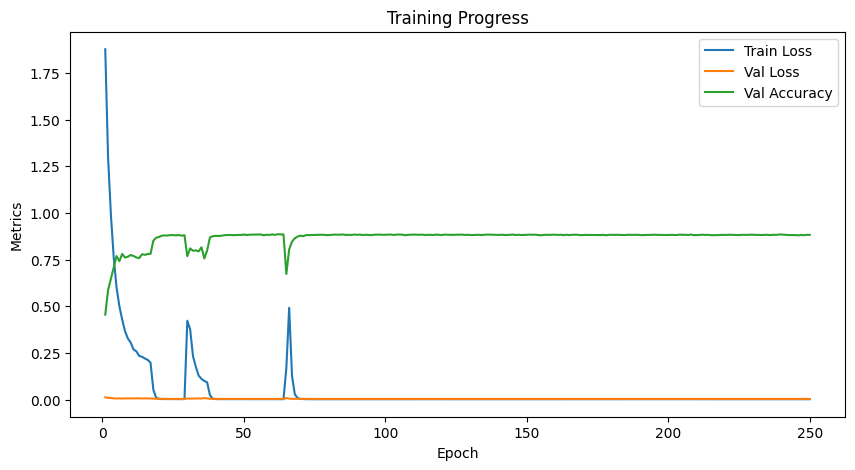

Testing [Test]: 100%|███████████████████████████████████| 79/79 [00:05<00:00, 14.52it/s, test_acc=87, test_loss=0.0035]


In [3]:
model = ResNet(input_channels=3, num_classes=10)
trainer = CIFARTrainer(model=model, batch_size=128, epoch=250, num_classes=10)
trainer.train()
trainer.test()

Files already downloaded and verified
Files already downloaded and verified
2024-05-23 03:45:52
Epoch 1 / 250


[Valid]: 100%|████████████████████████| 40/40 [00:02<00:00, 14.37it/s, val_acc=15.1, val_loss=0.028]


Validation loss decreased (inf --> 0.028005).  Saving model ...
2024-05-23 03:46:36
Epoch 2 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.34it/s, val_acc=22.8, val_loss=0.0253]


Validation loss decreased (0.028005 --> 0.025288).  Saving model ...
2024-05-23 03:47:21
Epoch 3 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.54it/s, val_acc=34.8, val_loss=0.0201]


Validation loss decreased (0.025288 --> 0.020068).  Saving model ...
2024-05-23 03:48:08
Epoch 4 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.92it/s, val_acc=41.8, val_loss=0.0177]


Validation loss decreased (0.020068 --> 0.017742).  Saving model ...
2024-05-23 03:48:53
Epoch 5 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.45it/s, val_acc=44.5, val_loss=0.0166]


Validation loss decreased (0.017742 --> 0.016622).  Saving model ...
2024-05-23 03:49:39
Epoch 6 / 250


[Valid]: 100%|█████████████████████████| 40/40 [00:02<00:00, 14.52it/s, val_acc=46, val_loss=0.0163]


Validation loss decreased (0.016622 --> 0.016263).  Saving model ...
2024-05-23 03:50:25
Epoch 7 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.21it/s, val_acc=42.1, val_loss=0.0188]


2024-05-23 03:51:10
Epoch 8 / 250


[Valid]: 100%|█████████████████████████| 40/40 [00:02<00:00, 14.23it/s, val_acc=41.1, val_loss=0.02]


2024-05-23 03:51:55
Epoch 9 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.38it/s, val_acc=47.7, val_loss=0.0162]


Validation loss decreased (0.016263 --> 0.016177).  Saving model ...
2024-05-23 03:52:40
Epoch 10 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.54it/s, val_acc=46.3, val_loss=0.0184]


2024-05-23 03:53:24
Epoch 11 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.41it/s, val_acc=46.7, val_loss=0.0179]


2024-05-23 03:54:08
Epoch 12 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.40it/s, val_acc=48.2, val_loss=0.0185]


2024-05-23 03:54:53
Epoch 13 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 13.84it/s, val_acc=45.5, val_loss=0.0199]


2024-05-23 03:55:38
Epoch 14 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.55it/s, val_acc=41.1, val_loss=0.0222]


2024-05-23 03:56:24
Epoch 15 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.46it/s, val_acc=45.2, val_loss=0.0199]


2024-05-23 03:57:09
Epoch 16 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.42it/s, val_acc=45.9, val_loss=0.0193]


2024-05-23 03:57:53
Epoch 17 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.39it/s, val_acc=45.5, val_loss=0.0208]


2024-05-23 03:58:39
Epoch 18 / 250


[Valid]: 100%|█████████████████████████| 40/40 [00:02<00:00, 14.63it/s, val_acc=45, val_loss=0.0209]


2024-05-23 03:59:24
Epoch 19 / 250


[Valid]: 100%|█████████████████████████| 40/40 [00:02<00:00, 14.56it/s, val_acc=44, val_loss=0.0208]


2024-05-23 04:00:10
Epoch 20 / 250
lr is updated to 0.05


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.95it/s, val_acc=57.4, val_loss=0.0138]


Validation loss decreased (0.016177 --> 0.013845).  Saving model ...
2024-05-23 04:00:55
Epoch 21 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.55it/s, val_acc=59.4, val_loss=0.0129]


Validation loss decreased (0.013845 --> 0.012906).  Saving model ...
2024-05-23 04:01:39
Epoch 22 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.28it/s, val_acc=59.8, val_loss=0.0125]


Validation loss decreased (0.012906 --> 0.012469).  Saving model ...
2024-05-23 04:02:24
Epoch 23 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.55it/s, val_acc=60.3, val_loss=0.0123]


Validation loss decreased (0.012469 --> 0.012330).  Saving model ...
2024-05-23 04:03:09
Epoch 24 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.38it/s, val_acc=60.6, val_loss=0.0123]


Validation loss decreased (0.012330 --> 0.012270).  Saving model ...
2024-05-23 04:03:55
Epoch 25 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.59it/s, val_acc=60.7, val_loss=0.0124]


2024-05-23 04:04:40
Epoch 26 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.39it/s, val_acc=60.7, val_loss=0.0125]


2024-05-23 04:05:25
Epoch 27 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.27it/s, val_acc=60.4, val_loss=0.0126]


2024-05-23 04:06:10
Epoch 28 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.42it/s, val_acc=60.2, val_loss=0.0129]


2024-05-23 04:06:55
Epoch 29 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.53it/s, val_acc=59.7, val_loss=0.0131]


2024-05-23 04:07:40
Epoch 30 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.44it/s, val_acc=59.7, val_loss=0.0133]


2024-05-23 04:08:24
Epoch 31 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.46it/s, val_acc=42.6, val_loss=0.0198]


2024-05-23 04:09:10
Epoch 32 / 250


[Valid]: 100%|████████████████████████| 40/40 [00:02<00:00, 14.36it/s, val_acc=45.5, val_loss=0.018]


2024-05-23 04:09:55
Epoch 33 / 250


[Valid]: 100%|█████████████████████████| 40/40 [00:02<00:00, 14.54it/s, val_acc=49, val_loss=0.0173]


2024-05-23 04:10:40
Epoch 34 / 250


[Valid]: 100%|█████████████████████████| 40/40 [00:02<00:00, 14.39it/s, val_acc=46.5, val_loss=0.02]


2024-05-23 04:11:25
Epoch 35 / 250
lr is updated to 0.025


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.43it/s, val_acc=58.3, val_loss=0.0134]


2024-05-23 04:12:09
Epoch 36 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.47it/s, val_acc=60.9, val_loss=0.0126]


2024-05-23 04:12:54
Epoch 37 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.44it/s, val_acc=60.9, val_loss=0.0125]


2024-05-23 04:13:39
Epoch 38 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.26it/s, val_acc=61.3, val_loss=0.0123]


2024-05-23 04:14:25
Epoch 39 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.35it/s, val_acc=61.1, val_loss=0.0123]


2024-05-23 04:15:09
Epoch 40 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.59it/s, val_acc=61.2, val_loss=0.0122]


Validation loss decreased (0.012270 --> 0.012247).  Saving model ...
2024-05-23 04:15:54
Epoch 41 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.25it/s, val_acc=61.1, val_loss=0.0123]


2024-05-23 04:16:40
Epoch 42 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.81it/s, val_acc=61.3, val_loss=0.0123]


2024-05-23 04:17:25
Epoch 43 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.44it/s, val_acc=61.2, val_loss=0.0124]


2024-05-23 04:18:12
Epoch 44 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.46it/s, val_acc=60.8, val_loss=0.0125]


2024-05-23 04:18:56
Epoch 45 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.10it/s, val_acc=61.1, val_loss=0.0126]


2024-05-23 04:19:41
Epoch 46 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.22it/s, val_acc=60.6, val_loss=0.0127]


2024-05-23 04:20:26
Epoch 47 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.96it/s, val_acc=60.8, val_loss=0.0129]


2024-05-23 04:21:12
Epoch 48 / 250


[Valid]: 100%|████████████████████████| 40/40 [00:02<00:00, 14.83it/s, val_acc=60.8, val_loss=0.013]


2024-05-23 04:21:57
Epoch 49 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.74it/s, val_acc=60.6, val_loss=0.0131]


2024-05-23 04:22:42
Epoch 50 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.61it/s, val_acc=60.6, val_loss=0.0133]


2024-05-23 04:23:26
Epoch 51 / 250
lr is updated to 0.0125


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.63it/s, val_acc=60.5, val_loss=0.0133]


2024-05-23 04:24:11
Epoch 52 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.33it/s, val_acc=60.4, val_loss=0.0134]


2024-05-23 04:24:55
Epoch 53 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.59it/s, val_acc=60.5, val_loss=0.0135]


2024-05-23 04:25:40
Epoch 54 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.90it/s, val_acc=60.2, val_loss=0.0136]


2024-05-23 04:26:25
Epoch 55 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.39it/s, val_acc=60.1, val_loss=0.0137]


2024-05-23 04:27:11
Epoch 56 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.84it/s, val_acc=60.3, val_loss=0.0137]


2024-05-23 04:27:56
Epoch 57 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.94it/s, val_acc=60.3, val_loss=0.0138]


2024-05-23 04:28:41
Epoch 58 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 15.28it/s, val_acc=60.3, val_loss=0.0138]


2024-05-23 04:29:27
Epoch 59 / 250


[Valid]: 100%|█████████████████████████| 40/40 [00:02<00:00, 14.01it/s, val_acc=60, val_loss=0.0139]


2024-05-23 04:30:11
Epoch 60 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.10it/s, val_acc=60.3, val_loss=0.0139]


2024-05-23 04:30:57
Epoch 61 / 250
lr is updated to 0.00625


[Valid]: 100%|████████████████████████| 40/40 [00:02<00:00, 14.34it/s, val_acc=60.6, val_loss=0.014]


2024-05-23 04:31:42
Epoch 62 / 250


[Valid]: 100%|████████████████████████| 40/40 [00:02<00:00, 14.39it/s, val_acc=60.1, val_loss=0.014]


2024-05-23 04:32:26
Epoch 63 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.92it/s, val_acc=60.3, val_loss=0.0141]


2024-05-23 04:33:12
Epoch 64 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.47it/s, val_acc=60.6, val_loss=0.0141]


2024-05-23 04:33:57
Epoch 65 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.64it/s, val_acc=60.4, val_loss=0.0141]


2024-05-23 04:34:41
Epoch 66 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.97it/s, val_acc=60.3, val_loss=0.0142]


2024-05-23 04:35:24
Epoch 67 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.96it/s, val_acc=60.2, val_loss=0.0143]


2024-05-23 04:36:10
Epoch 68 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.47it/s, val_acc=59.9, val_loss=0.0143]


2024-05-23 04:36:56
Epoch 69 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.57it/s, val_acc=60.3, val_loss=0.0142]


2024-05-23 04:37:42
Epoch 70 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.65it/s, val_acc=60.5, val_loss=0.0143]


2024-05-23 04:38:26
Epoch 71 / 250
lr is updated to 0.003125


[Valid]: 100%|█████████████████████████| 40/40 [00:02<00:00, 14.32it/s, val_acc=60, val_loss=0.0143]


2024-05-23 04:39:11
Epoch 72 / 250


[Valid]: 100%|█████████████████████████| 40/40 [00:02<00:00, 14.35it/s, val_acc=60, val_loss=0.0144]


2024-05-23 04:39:56
Epoch 73 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.60it/s, val_acc=59.9, val_loss=0.0144]


2024-05-23 04:40:41
Epoch 74 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 15.29it/s, val_acc=59.7, val_loss=0.0144]


2024-05-23 04:41:27
Epoch 75 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.53it/s, val_acc=59.8, val_loss=0.0144]


2024-05-23 04:42:12
Epoch 76 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.40it/s, val_acc=59.8, val_loss=0.0144]


2024-05-23 04:42:56
Epoch 77 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.51it/s, val_acc=59.8, val_loss=0.0144]


2024-05-23 04:43:40
Epoch 78 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.48it/s, val_acc=59.8, val_loss=0.0145]


2024-05-23 04:44:25
Epoch 79 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.50it/s, val_acc=59.9, val_loss=0.0145]


2024-05-23 04:45:09
Epoch 80 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.31it/s, val_acc=59.7, val_loss=0.0145]


2024-05-23 04:45:53
Epoch 81 / 250
lr is updated to 0.0015625


[Valid]: 100%|█████████████████████████| 40/40 [00:02<00:00, 14.35it/s, val_acc=60, val_loss=0.0145]


2024-05-23 04:46:38
Epoch 82 / 250


[Valid]: 100%|█████████████████████████| 40/40 [00:02<00:00, 14.24it/s, val_acc=60, val_loss=0.0145]


2024-05-23 04:47:23
Epoch 83 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.59it/s, val_acc=60.2, val_loss=0.0145]


2024-05-23 04:48:08
Epoch 84 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 13.84it/s, val_acc=59.7, val_loss=0.0145]


2024-05-23 04:48:53
Epoch 85 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.54it/s, val_acc=59.9, val_loss=0.0145]


2024-05-23 04:49:39
Epoch 86 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.66it/s, val_acc=59.9, val_loss=0.0146]


2024-05-23 04:50:23
Epoch 87 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.47it/s, val_acc=60.1, val_loss=0.0146]


2024-05-23 04:51:07
Epoch 88 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.84it/s, val_acc=59.9, val_loss=0.0146]


2024-05-23 04:51:51
Epoch 89 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.38it/s, val_acc=59.7, val_loss=0.0146]


2024-05-23 04:52:37
Epoch 90 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.48it/s, val_acc=59.7, val_loss=0.0146]


2024-05-23 04:53:21
Epoch 91 / 250
lr is updated to 0.00078125


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.15it/s, val_acc=60.1, val_loss=0.0146]


2024-05-23 04:54:07
Epoch 92 / 250


[Valid]: 100%|█████████████████████████| 40/40 [00:02<00:00, 13.94it/s, val_acc=60, val_loss=0.0146]


2024-05-23 04:54:52
Epoch 93 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.00it/s, val_acc=59.9, val_loss=0.0146]


2024-05-23 04:55:38
Epoch 94 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.05it/s, val_acc=59.7, val_loss=0.0146]


2024-05-23 04:56:23
Epoch 95 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.10it/s, val_acc=59.7, val_loss=0.0146]


2024-05-23 04:57:09
Epoch 96 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.07it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 04:57:54
Epoch 97 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.73it/s, val_acc=59.9, val_loss=0.0146]


2024-05-23 04:58:39
Epoch 98 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.22it/s, val_acc=59.7, val_loss=0.0147]


2024-05-23 04:59:26
Epoch 99 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.07it/s, val_acc=59.7, val_loss=0.0147]


2024-05-23 05:00:11
Epoch 100 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 15.06it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 05:00:57
Epoch 101 / 250
lr is updated to 0.000390625


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 15.03it/s, val_acc=59.8, val_loss=0.0147]


2024-05-23 05:01:44
Epoch 102 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.43it/s, val_acc=60.1, val_loss=0.0147]


2024-05-23 05:02:29
Epoch 103 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 13.50it/s, val_acc=60.2, val_loss=0.0147]


2024-05-23 05:03:14
Epoch 104 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.06it/s, val_acc=59.7, val_loss=0.0147]


2024-05-23 05:04:00
Epoch 105 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.26it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 05:04:44
Epoch 106 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.29it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 05:05:31
Epoch 107 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.95it/s, val_acc=59.8, val_loss=0.0147]


2024-05-23 05:06:18
Epoch 108 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.43it/s, val_acc=59.7, val_loss=0.0147]


2024-05-23 05:07:04
Epoch 109 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.31it/s, val_acc=59.6, val_loss=0.0147]


2024-05-23 05:07:49
Epoch 110 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.27it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 05:08:34
Epoch 111 / 250
lr is updated to 0.0001953125


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.33it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 05:09:19
Epoch 112 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.65it/s, val_acc=59.7, val_loss=0.0147]


2024-05-23 05:10:04
Epoch 113 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.38it/s, val_acc=59.7, val_loss=0.0147]


2024-05-23 05:10:51
Epoch 114 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 13.83it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 05:11:37
Epoch 115 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 15.08it/s, val_acc=60.2, val_loss=0.0147]


2024-05-23 05:12:22
Epoch 116 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 15.31it/s, val_acc=59.6, val_loss=0.0147]


2024-05-23 05:13:07
Epoch 117 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 15.06it/s, val_acc=59.7, val_loss=0.0147]


2024-05-23 05:13:52
Epoch 118 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.24it/s, val_acc=59.7, val_loss=0.0147]


2024-05-23 05:14:37
Epoch 119 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.43it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 05:15:22
Epoch 120 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.13it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 05:16:07
Epoch 121 / 250
lr is updated to 9.765625e-05


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.32it/s, val_acc=59.8, val_loss=0.0147]


2024-05-23 05:16:52
Epoch 122 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.36it/s, val_acc=59.5, val_loss=0.0147]


2024-05-23 05:17:37
Epoch 123 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.41it/s, val_acc=59.5, val_loss=0.0147]


2024-05-23 05:18:22
Epoch 124 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.04it/s, val_acc=60.3, val_loss=0.0147]


2024-05-23 05:19:07
Epoch 125 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.18it/s, val_acc=59.8, val_loss=0.0147]


2024-05-23 05:19:52
Epoch 126 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.36it/s, val_acc=59.8, val_loss=0.0147]


2024-05-23 05:20:36
Epoch 127 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.04it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 05:21:22
Epoch 128 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.33it/s, val_acc=59.8, val_loss=0.0147]


2024-05-23 05:22:08
Epoch 129 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 13.48it/s, val_acc=59.8, val_loss=0.0147]


2024-05-23 05:22:55
Epoch 130 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 13.87it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 05:23:40
Epoch 131 / 250
lr is updated to 4.8828125e-05


[Valid]: 100%|█████████████████████████| 40/40 [00:02<00:00, 14.88it/s, val_acc=60, val_loss=0.0147]


2024-05-23 05:24:26
Epoch 132 / 250


[Valid]: 100%|█████████████████████████| 40/40 [00:02<00:00, 14.57it/s, val_acc=60, val_loss=0.0147]


2024-05-23 05:25:11
Epoch 133 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.50it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 05:25:55
Epoch 134 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.80it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 05:26:39
Epoch 135 / 250


[Valid]: 100%|█████████████████████████| 40/40 [00:02<00:00, 14.02it/s, val_acc=60, val_loss=0.0147]


2024-05-23 05:27:25
Epoch 136 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.58it/s, val_acc=59.7, val_loss=0.0147]


2024-05-23 05:28:10
Epoch 137 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.45it/s, val_acc=59.8, val_loss=0.0147]


2024-05-23 05:28:55
Epoch 138 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.42it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 05:29:39
Epoch 139 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.11it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 05:30:25
Epoch 140 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.48it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 05:31:11
Epoch 141 / 250
lr is updated to 2.44140625e-05


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.30it/s, val_acc=59.7, val_loss=0.0148]


2024-05-23 05:31:56
Epoch 142 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.27it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 05:32:41
Epoch 143 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.37it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 05:33:26
Epoch 144 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.43it/s, val_acc=59.8, val_loss=0.0147]


2024-05-23 05:34:13
Epoch 145 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.62it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 05:34:59
Epoch 146 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.60it/s, val_acc=59.6, val_loss=0.0147]


2024-05-23 05:35:43
Epoch 147 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.90it/s, val_acc=59.6, val_loss=0.0147]


2024-05-23 05:36:29
Epoch 148 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.47it/s, val_acc=59.8, val_loss=0.0147]


2024-05-23 05:37:14
Epoch 149 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.44it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 05:37:58
Epoch 150 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.52it/s, val_acc=59.7, val_loss=0.0147]


2024-05-23 05:38:42
Epoch 151 / 250
lr is updated to 1.220703125e-05


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.39it/s, val_acc=59.8, val_loss=0.0147]


2024-05-23 05:39:27
Epoch 152 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.27it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 05:40:13
Epoch 153 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.92it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 05:40:59
Epoch 154 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.47it/s, val_acc=59.8, val_loss=0.0147]


2024-05-23 05:41:44
Epoch 155 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.42it/s, val_acc=60.1, val_loss=0.0147]


2024-05-23 05:42:30
Epoch 156 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.71it/s, val_acc=59.6, val_loss=0.0147]


2024-05-23 05:43:15
Epoch 157 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.35it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 05:44:00
Epoch 158 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.29it/s, val_acc=59.5, val_loss=0.0147]


2024-05-23 05:44:45
Epoch 159 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.19it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 05:45:30
Epoch 160 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.02it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 05:46:17
Epoch 161 / 250
lr is updated to 6.103515625e-06


[Valid]: 100%|█████████████████████████| 40/40 [00:02<00:00, 14.75it/s, val_acc=60, val_loss=0.0147]


2024-05-23 05:47:02
Epoch 162 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.24it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 05:47:47
Epoch 163 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.35it/s, val_acc=59.8, val_loss=0.0147]


2024-05-23 05:48:31
Epoch 164 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.35it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 05:49:16
Epoch 165 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.37it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 05:50:02
Epoch 166 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.54it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 05:50:47
Epoch 167 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.50it/s, val_acc=59.6, val_loss=0.0147]


2024-05-23 05:51:32
Epoch 168 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:03<00:00, 13.01it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 05:52:19
Epoch 169 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.33it/s, val_acc=59.6, val_loss=0.0147]


2024-05-23 05:53:04
Epoch 170 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.75it/s, val_acc=59.5, val_loss=0.0147]


2024-05-23 05:53:50
Epoch 171 / 250
lr is updated to 3.0517578125e-06


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.07it/s, val_acc=59.7, val_loss=0.0147]


2024-05-23 05:54:35
Epoch 172 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.32it/s, val_acc=59.8, val_loss=0.0147]


2024-05-23 05:55:20
Epoch 173 / 250


[Valid]: 100%|█████████████████████████| 40/40 [00:02<00:00, 14.31it/s, val_acc=60, val_loss=0.0147]


2024-05-23 05:56:06
Epoch 174 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.15it/s, val_acc=59.6, val_loss=0.0147]


2024-05-23 05:56:51
Epoch 175 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.52it/s, val_acc=59.8, val_loss=0.0147]


2024-05-23 05:57:37
Epoch 176 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.34it/s, val_acc=59.8, val_loss=0.0147]


2024-05-23 05:58:21
Epoch 177 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.52it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 05:59:06
Epoch 178 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.49it/s, val_acc=59.8, val_loss=0.0147]


2024-05-23 05:59:51
Epoch 179 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 15.12it/s, val_acc=59.7, val_loss=0.0147]


2024-05-23 06:00:36
Epoch 180 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.65it/s, val_acc=59.8, val_loss=0.0147]


2024-05-23 06:01:22
Epoch 181 / 250
lr is updated to 1.52587890625e-06


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.22it/s, val_acc=60.1, val_loss=0.0147]


2024-05-23 06:02:07
Epoch 182 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.66it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 06:02:52
Epoch 183 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.21it/s, val_acc=59.7, val_loss=0.0147]


2024-05-23 06:03:37
Epoch 184 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.16it/s, val_acc=59.8, val_loss=0.0147]


2024-05-23 06:04:23
Epoch 185 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.65it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 06:05:07
Epoch 186 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.03it/s, val_acc=59.8, val_loss=0.0147]


2024-05-23 06:05:53
Epoch 187 / 250


[Valid]: 100%|█████████████████████████| 40/40 [00:02<00:00, 14.10it/s, val_acc=60, val_loss=0.0147]


2024-05-23 06:06:38
Epoch 188 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.08it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 06:07:24
Epoch 189 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.57it/s, val_acc=59.6, val_loss=0.0147]


2024-05-23 06:08:09
Epoch 190 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.31it/s, val_acc=59.8, val_loss=0.0147]


2024-05-23 06:08:55
Epoch 191 / 250
lr is updated to 7.62939453125e-07


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.59it/s, val_acc=59.7, val_loss=0.0147]


2024-05-23 06:09:40
Epoch 192 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.38it/s, val_acc=59.7, val_loss=0.0147]


2024-05-23 06:10:26
Epoch 193 / 250


[Valid]: 100%|█████████████████████████| 40/40 [00:02<00:00, 14.73it/s, val_acc=60, val_loss=0.0147]


2024-05-23 06:11:11
Epoch 194 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.16it/s, val_acc=59.8, val_loss=0.0147]


2024-05-23 06:11:57
Epoch 195 / 250


[Valid]: 100%|█████████████████████████| 40/40 [00:02<00:00, 14.81it/s, val_acc=60, val_loss=0.0147]


2024-05-23 06:12:41
Epoch 196 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.86it/s, val_acc=59.6, val_loss=0.0147]


2024-05-23 06:13:27
Epoch 197 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.67it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 06:14:13
Epoch 198 / 250


[Valid]: 100%|█████████████████████████| 40/40 [00:02<00:00, 14.93it/s, val_acc=60, val_loss=0.0147]


2024-05-23 06:14:58
Epoch 199 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.37it/s, val_acc=60.1, val_loss=0.0147]


2024-05-23 06:15:43
Epoch 200 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.43it/s, val_acc=59.8, val_loss=0.0147]


2024-05-23 06:16:28
Epoch 201 / 250
lr is updated to 3.814697265625e-07


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.69it/s, val_acc=59.7, val_loss=0.0147]


2024-05-23 06:17:14
Epoch 202 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.50it/s, val_acc=59.7, val_loss=0.0147]


2024-05-23 06:17:59
Epoch 203 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.29it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 06:18:43
Epoch 204 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.63it/s, val_acc=59.9, val_loss=0.0148]


2024-05-23 06:19:29
Epoch 205 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.69it/s, val_acc=59.7, val_loss=0.0147]


2024-05-23 06:20:15
Epoch 206 / 250


[Valid]: 100%|█████████████████████████| 40/40 [00:02<00:00, 14.00it/s, val_acc=60, val_loss=0.0147]


2024-05-23 06:21:01
Epoch 207 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.12it/s, val_acc=59.7, val_loss=0.0147]


2024-05-23 06:21:46
Epoch 208 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.15it/s, val_acc=59.6, val_loss=0.0147]


2024-05-23 06:22:32
Epoch 209 / 250


[Valid]: 100%|█████████████████████████| 40/40 [00:02<00:00, 14.43it/s, val_acc=60, val_loss=0.0147]


2024-05-23 06:23:16
Epoch 210 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.75it/s, val_acc=59.5, val_loss=0.0147]


2024-05-23 06:24:00
Epoch 211 / 250
lr is updated to 1.9073486328125e-07


[Valid]: 100%|█████████████████████████| 40/40 [00:02<00:00, 13.97it/s, val_acc=60, val_loss=0.0148]


2024-05-23 06:24:47
Epoch 212 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.24it/s, val_acc=59.8, val_loss=0.0147]


2024-05-23 06:25:32
Epoch 213 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.75it/s, val_acc=59.8, val_loss=0.0147]


2024-05-23 06:26:17
Epoch 214 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.90it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 06:27:02
Epoch 215 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 13.94it/s, val_acc=59.7, val_loss=0.0147]


2024-05-23 06:27:48
Epoch 216 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.72it/s, val_acc=59.8, val_loss=0.0147]


2024-05-23 06:28:34
Epoch 217 / 250


[Valid]: 100%|█████████████████████████| 40/40 [00:02<00:00, 14.56it/s, val_acc=60, val_loss=0.0147]


2024-05-23 06:29:19
Epoch 218 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.82it/s, val_acc=59.7, val_loss=0.0147]


2024-05-23 06:30:05
Epoch 219 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.44it/s, val_acc=59.6, val_loss=0.0147]


2024-05-23 06:30:50
Epoch 220 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.59it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 06:31:34
Epoch 221 / 250
lr is updated to 9.5367431640625e-08


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.29it/s, val_acc=59.7, val_loss=0.0147]


2024-05-23 06:32:19
Epoch 222 / 250


[Valid]: 100%|█████████████████████████| 40/40 [00:02<00:00, 14.54it/s, val_acc=60, val_loss=0.0147]


2024-05-23 06:33:03
Epoch 223 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.76it/s, val_acc=59.8, val_loss=0.0147]


2024-05-23 06:33:50
Epoch 224 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.55it/s, val_acc=59.8, val_loss=0.0147]


2024-05-23 06:34:36
Epoch 225 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.68it/s, val_acc=60.1, val_loss=0.0147]


2024-05-23 06:35:21
Epoch 226 / 250


[Valid]: 100%|█████████████████████████| 40/40 [00:02<00:00, 14.48it/s, val_acc=60, val_loss=0.0147]


2024-05-23 06:36:06
Epoch 227 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.57it/s, val_acc=59.7, val_loss=0.0147]


2024-05-23 06:36:52
Epoch 228 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.28it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 06:37:37
Epoch 229 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.33it/s, val_acc=59.8, val_loss=0.0147]


2024-05-23 06:38:22
Epoch 230 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.37it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 06:39:07
Epoch 231 / 250
lr is updated to 4.76837158203125e-08


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.07it/s, val_acc=59.8, val_loss=0.0147]


2024-05-23 06:39:52
Epoch 232 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.24it/s, val_acc=59.7, val_loss=0.0148]


2024-05-23 06:40:38
Epoch 233 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.25it/s, val_acc=59.8, val_loss=0.0147]


2024-05-23 06:41:23
Epoch 234 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 13.64it/s, val_acc=59.9, val_loss=0.0148]


2024-05-23 06:42:08
Epoch 235 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 13.50it/s, val_acc=59.8, val_loss=0.0147]


2024-05-23 06:42:53
Epoch 236 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.89it/s, val_acc=59.7, val_loss=0.0147]


2024-05-23 06:43:39
Epoch 237 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.83it/s, val_acc=59.8, val_loss=0.0147]


2024-05-23 06:44:25
Epoch 238 / 250


[Valid]: 100%|█████████████████████████| 40/40 [00:02<00:00, 14.29it/s, val_acc=60, val_loss=0.0147]


2024-05-23 06:45:10
Epoch 239 / 250


[Valid]: 100%|█████████████████████████| 40/40 [00:02<00:00, 14.74it/s, val_acc=60, val_loss=0.0147]


2024-05-23 06:45:55
Epoch 240 / 250


[Valid]: 100%|█████████████████████████| 40/40 [00:02<00:00, 14.34it/s, val_acc=60, val_loss=0.0147]


2024-05-23 06:46:40
Epoch 241 / 250
lr is updated to 2.384185791015625e-08


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.08it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 06:47:25
Epoch 242 / 250


[Valid]: 100%|█████████████████████████| 40/40 [00:02<00:00, 14.87it/s, val_acc=60, val_loss=0.0147]


2024-05-23 06:48:10
Epoch 243 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.09it/s, val_acc=59.7, val_loss=0.0147]


2024-05-23 06:48:56
Epoch 244 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.34it/s, val_acc=60.2, val_loss=0.0147]


2024-05-23 06:49:41
Epoch 245 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.12it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 06:50:26
Epoch 246 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.32it/s, val_acc=59.7, val_loss=0.0147]


2024-05-23 06:51:11
Epoch 247 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.74it/s, val_acc=59.6, val_loss=0.0147]


2024-05-23 06:51:57
Epoch 248 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.07it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 06:52:44
Epoch 249 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.10it/s, val_acc=59.9, val_loss=0.0147]


2024-05-23 06:53:29
Epoch 250 / 250


[Valid]: 100%|███████████████████████| 40/40 [00:02<00:00, 14.15it/s, val_acc=59.9, val_loss=0.0147]


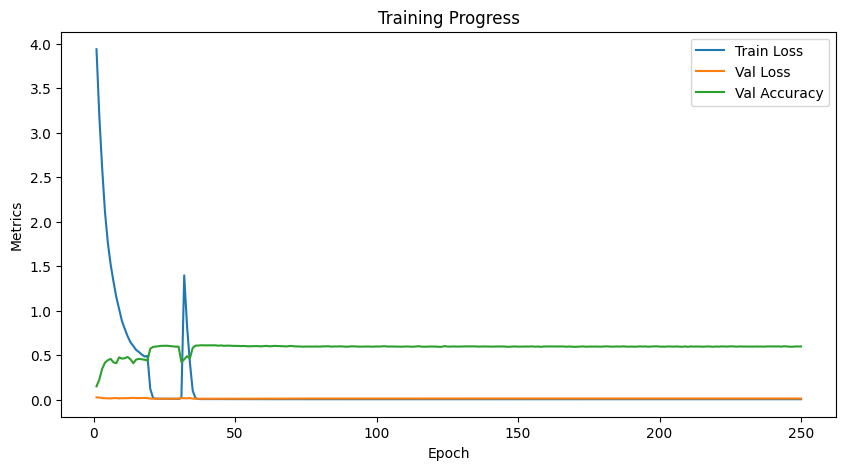

Testing [Test]: 100%|█████████████████████████████████| 79/79 [00:05<00:00, 14.01it/s, test_acc=59.8, test_loss=0.0144]


In [4]:
model_100 = ResNet(input_channels=3, num_classes=100)
trainer_100 = CIFARTrainer(model=model_100, batch_size=128, epoch=250, num_classes=100)
trainer_100.train()
trainer_100.test()